# Gradient Boost Regressor - Model Evaluation

In [4]:
# standard modules
import sys
import os

# data and vizualisation models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# machine learning
import joblib
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_validate, learning_curve, train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor


# Get the current working directory
current_dir = os.getcwd()

# add 'main' to the path
main_dir = os.path.dirname(current_dir)
sys.path.append(main_dir)

# data preprocessing and scaling
from feature_engin.main_feature_engin import merge_all_datasets


Downloading the preprocessed and scaled (only traget not scaled) dataset from Google Cloud Bucket

In [5]:
# fetching data
raw_data = merge_all_datasets()


Loaded germany_electricity_generation_2018-2023.csv successfully.
Loaded weather_north_hourly.csv successfully.
Loaded weather_south_hourly.csv successfully.
Loaded weather_brocken_hourly.csv successfully.
Loaded holidays.csv successfully.
Loaded PMI_germany.csv successfully.
Loaded coal_price.csv successfully.
Loaded ttf_price.csv successfully.
Loaded oil_price.csv successfully.
The DataFrame has 207264 rows before deleting NaN rows.
The DataFrame has 207164 rows AFTER deleting NaN rows.


Copying the data for security reasons

In [6]:
# copying
data = raw_data.copy()
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207164 entries, 2018-01-02 00:00:00+00:00 to 2023-11-29 10:45:00+00:00
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   fractional_hour         207164 non-null  float64
 1   day_of_week             207164 non-null  float64
 2   week_of_year            207164 non-null  float64
 3   month                   207164 non-null  float64
 4   year                    207164 non-null  float64
 5   hydro_storage_in        207164 non-null  float64
 6   cross_border            207164 non-null  float64
 7   nuclear                 207164 non-null  float64
 8   hydro                   207164 non-null  float64
 9   biomass                 207164 non-null  float64
 10  lignite                 207164 non-null  float64
 11  hard_coal               207164 non-null  float64
 12  oil                     207164 non-null  float64
 13  coal_gas                2071

In [7]:
# checking if feature is unscaled
data["day_ahead_price"]


2018-01-02 00:00:00+00:00     14.99
2018-01-02 00:15:00+00:00     14.99
2018-01-02 00:30:00+00:00     14.99
2018-01-02 00:45:00+00:00     14.99
2018-01-02 01:00:00+00:00     13.63
                              ...  
2023-11-29 09:45:00+00:00    133.72
2023-11-29 10:00:00+00:00    130.00
2023-11-29 10:15:00+00:00    130.00
2023-11-29 10:30:00+00:00    130.00
2023-11-29 10:45:00+00:00    130.00
Name: day_ahead_price, Length: 207164, dtype: float64

In [8]:
# scale data with StandardScaler
scaler = StandardScaler()

# Reshape data["day_ahead_price"] to a 2D array as scaler expects 2D inputs
day_ahead_price_scaled = scaler.fit_transform(data["day_ahead_price"].values.reshape(-1, 1))

# Replace the original target variable in the dataframe with the scaled values
data["day_ahead_price_scaled"] = day_ahead_price_scaled.flatten()

# save the unscaled data in an df for later use
unscaled_target = data[['day_ahead_price']].copy()

# drop unscaled target from data
data.drop('day_ahead_price', axis=1, inplace=True)

data["day_ahead_price_scaled"]


2018-01-02 00:00:00+00:00   -0.759007
2018-01-02 00:15:00+00:00   -0.759007
2018-01-02 00:30:00+00:00   -0.759007
2018-01-02 00:45:00+00:00   -0.759007
2018-01-02 01:00:00+00:00   -0.772712
                               ...   
2023-11-29 09:45:00+00:00    0.437455
2023-11-29 10:00:00+00:00    0.399968
2023-11-29 10:15:00+00:00    0.399968
2023-11-29 10:30:00+00:00    0.399968
2023-11-29 10:45:00+00:00    0.399968
Name: day_ahead_price_scaled, Length: 207164, dtype: float64

### Cross-Correlation Matrix

Creating a cross-correlation matrix to evaluate feature importance and delete features with less than 0.1 cross-corr coefficient

In [9]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# check cross-correlation with target
corr_matrix["day_ahead_price_scaled"].abs().sort_values()

# Calculate the absolute correlation with the target variable
target_corr = corr_matrix["day_ahead_price_scaled"].abs()

# Filter out features with correlation less than 0.1
selected_features = target_corr[target_corr >= 0.1].index.tolist()

# Create a new dataset with the selected features
data = data[selected_features]

# before 43 features -> now 28
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207164 entries, 2018-01-02 00:00:00+00:00 to 2023-11-29 10:45:00+00:00
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   day_of_week             207164 non-null  float64
 1   week_of_year            207164 non-null  float64
 2   month                   207164 non-null  float64
 3   year                    207164 non-null  float64
 4   hydro_storage_in        207164 non-null  float64
 5   cross_border            207164 non-null  float64
 6   nuclear                 207164 non-null  float64
 7   hydro                   207164 non-null  float64
 8   biomass                 207164 non-null  float64
 9   lignite                 207164 non-null  float64
 10  hard_coal               207164 non-null  float64
 11  oil                     207164 non-null  float64
 12  coal_gas                207164 non-null  float64
 13  nat_gas                 2071

# Split Data

take last two weeks of data for independent prediction and train_test split the rest

In [10]:
# sortby the datetime index
data = data.sort_index()

# Identify the Split Point
split_date = data.index.max() - pd.Timedelta(weeks=2)

data_mod = data[data.index <= split_date]
last_two_weeks_data = data[data.index > split_date]

# Check the number of entries in the split datasets
print("Data up to the last two weeks:", data_mod.shape[0])
print("Last two weeks data:", last_two_weeks_data.shape[0])


Data up to the last two weeks: 205820
Last two weeks data: 1344


In [11]:
data_mod.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205820 entries, 2018-01-02 00:00:00+00:00 to 2023-11-15 10:45:00+00:00
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   day_of_week             205820 non-null  float64
 1   week_of_year            205820 non-null  float64
 2   month                   205820 non-null  float64
 3   year                    205820 non-null  float64
 4   hydro_storage_in        205820 non-null  float64
 5   cross_border            205820 non-null  float64
 6   nuclear                 205820 non-null  float64
 7   hydro                   205820 non-null  float64
 8   biomass                 205820 non-null  float64
 9   lignite                 205820 non-null  float64
 10  hard_coal               205820 non-null  float64
 11  oil                     205820 non-null  float64
 12  coal_gas                205820 non-null  float64
 13  nat_gas                 2058

In [12]:
last_two_weeks_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1344 entries, 2023-11-15 11:00:00+00:00 to 2023-11-29 10:45:00+00:00
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   day_of_week             1344 non-null   float64
 1   week_of_year            1344 non-null   float64
 2   month                   1344 non-null   float64
 3   year                    1344 non-null   float64
 4   hydro_storage_in        1344 non-null   float64
 5   cross_border            1344 non-null   float64
 6   nuclear                 1344 non-null   float64
 7   hydro                   1344 non-null   float64
 8   biomass                 1344 non-null   float64
 9   lignite                 1344 non-null   float64
 10  hard_coal               1344 non-null   float64
 11  oil                     1344 non-null   float64
 12  coal_gas                1344 non-null   float64
 13  nat_gas                 1344 non-null   float

Now train test split:

In [13]:
# Prepare your feature set and target variable
X = data_mod.drop(columns=['day_ahead_price_scaled'])
y = data_mod['day_ahead_price_scaled']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Gradient Boost Regressor
## Instantiate a Simple Model and Cross-Validate

Scoring method is R^2 to penalize high errors

In [108]:
# Instantiate the model
simple_gbm_model = GradientBoostingRegressor(random_state=42)

# Fit the model on the training data
simple_gbm_model.fit(X_train, y_train)


GradientBoostingRegressor(random_state=42)

In [109]:
# Predict on the test data
y_pred = simple_gbm_model.predict(X_test)

# Calculate the performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 0.04393522633138591
R-squared: 0.9575384975616074


## Learning Curve for GBR

In [110]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = GradientBoostingRegressor(random_state=42),
    X = X_train,
    y = y_train,
    train_sizes = train_sizes,
    cv = 5,
    scoring = 'r2',
    verbose = 2
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)


[learning_curve] Training set sizes: [ 13172  26344  39517  52689  65862  79034  92206 105379 118551 131724]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time=   9.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.8s remaining:    0.0s


[CV] END .................................................... total time=  19.0s
[CV] END .................................................... total time=  28.1s
[CV] END .................................................... total time=  38.5s
[CV] END .................................................... total time=  46.3s
[CV] END .................................................... total time=  55.7s
[CV] END .................................................... total time= 1.1min
[CV] END .................................................... total time= 1.3min
[CV] END .................................................... total time= 1.4min
[CV] END .................................................... total time= 1.6min
[CV] END .................................................... total time=   9.5s
[CV] END .................................................... total time=  18.7s
[CV] END .................................................... total time=  28.5s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 43.3min finished


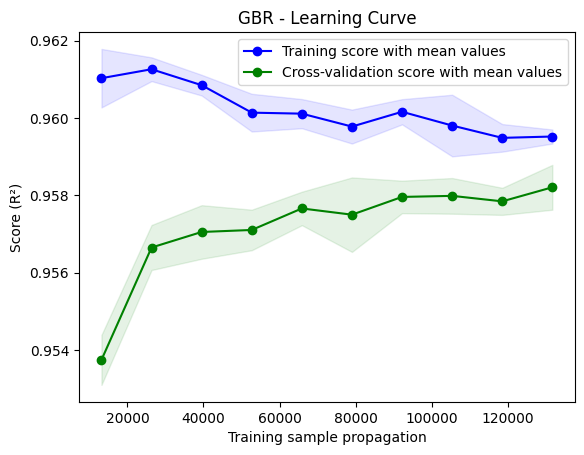

In [111]:
plt.figure()
plt.title("GBR - Learning Curve")
plt.xlabel("Training sample propagation")
plt.ylabel("Score (R²)")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="b")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training score with mean values")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score with mean values")

plt.legend(loc="best")
plt.show()


## Grid Search
Further improoving model by doing grid search on 'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7] and 'learning_rate': [0.01, 0.1, 0.2]

In [112]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV


# Parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Create a base model
gbm = GradientBoostingRegressor(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=3, scoring='r2')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best parameters
grid_search.best_params_


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.711 total time= 3.3min
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.716 total time= 3.3min
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.716 total time= 3.4min
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.870 total time= 6.6min
[CV 3/3] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.870 total time= 6.8min
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=200;, score=0.866 total time= 6.8min
[CV 2/3] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.800 total time= 5.6min
[CV 1/3] END learning_rate=0.01, max_depth=5, n_estimators=100;, score=0.799 total time= 5.9min
[CV 1/3] END learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.915 total time=10.0min
[CV 2/3] END learning_rate=0.01, max_depth=3, n_estimators=300;, score=0.918 total time=10.3min
[CV 3/3] END learning_rate=0.01, max_dep

{'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}

Best model: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}

Next step: grid search 'min_samples_leaf' and 'min_samples_split':

- keep "min_samples_leaf" = 1

- increasing 'min_samples_split' to prevent overfitting while optimizing for best_parm

 A higher value for min_samples_split restricts the tree from growing too complex. It requires more samples at a node to consider a split, thus reducing the total number of splits, leading to simpler trees and potentially lower computational effort.

In [113]:
param_grid = {
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
}

# Instantiate the model with your best parameters
best_gbm_model = GradientBoostingRegressor(learning_rate=0.2, max_depth=7, n_estimators=300, random_state=42)

# Set up the grid search
grid_search = GridSearchCV(estimator=best_gbm_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=3)

# Run the Grid search
grid_search.fit(X_train, y_train)

print("Best parameter for min_samples_split:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV 1/5] END ...............min_samples_split=2;, score=0.993 total time=29.2min
[CV 5/5] END ...............min_samples_split=2;, score=0.993 total time=29.5min
[CV 1/5] END ...............min_samples_split=4;, score=0.993 total time=29.6min
[CV 3/5] END ...............min_samples_split=4;, score=0.993 total time=29.7min
[CV 3/5] END ...............min_samples_split=2;, score=0.993 total time=29.9min
[CV 2/5] END ...............min_samples_split=4;, score=0.993 total time=30.2min
[CV 2/5] END ...............min_samples_split=2;, score=0.993 total time=30.6min
[CV 4/5] END ...............min_samples_split=2;, score=0.993 total time=30.6min
[CV 5/5] END ...............min_samples_split=4;, score=0.993 total time=29.2min
[CV 1/5] END ...............min_samples_split=6;, score=0.993 total time=29.1min
[CV 3/5] END ...............min_samples_split=6;, score=0.993 total time=29.2min
[CV 2/5] END ...............min_samples_split=6;, score=0.993 total time=29.6min
[CV 4/5] END ...............

# Evaluating Best GBR Model

## Training MSE and R^2

In [114]:
best_gbm_model = GradientBoostingRegressor(learning_rate=0.2, max_depth=7, n_estimators=300, min_samples_split=10, random_state=42)

best_gbm_model.fit(X_train, y_train)

# Save the model to a file
joblib.dump(best_gbm_model, 'best_gbm_model.pkl')


# Predict on the training data
y_train_pred = best_gbm_model.predict(X_train)

# Calculate and print the performance metrics
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f"Training Mean Squared Error: {mse_train}")
print(f"Training R-squared: {r2_train}")


Training Mean Squared Error: 0.0032801230324506912
Training R-squared: 0.9967143268050016


## Test MSE and R^2

In [115]:
y_test_pred = best_gbm_model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Mean Squared Error: {mse_test}")
print(f"Test R-squared: {r2_test}")


Test Mean Squared Error: 0.006760460493644192
Test R-squared: 0.9934663063399206


## Cross-validation of MSE and R^2

In [97]:
# Instantiate the model with the optimal hyperparameters
best_gbm_model_cv = GradientBoostingRegressor(learning_rate=0.2, max_depth=7, n_estimators=300, min_samples_split=10, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(best_gbm_model_cv, X_train, y_train, cv=5, scoring='r2')

# Calculate the mean and standard deviation of the scores
cv_mean = np.mean(cv_scores)
cv_std = np.std(cv_scores)

print(f"Cross-Validation R-squared Scores: {cv_scores}")
print(f"Mean R-squared: {cv_mean:.4f}, Standard Deviation: {cv_std:.4f}")


Cross-Validation R-squared Scores: [0.99302618 0.99317717 0.99286773 0.99268422 0.99272454]
Mean R-squared: 0.9929, Standard Deviation: 0.0002


# Check Feature Importance

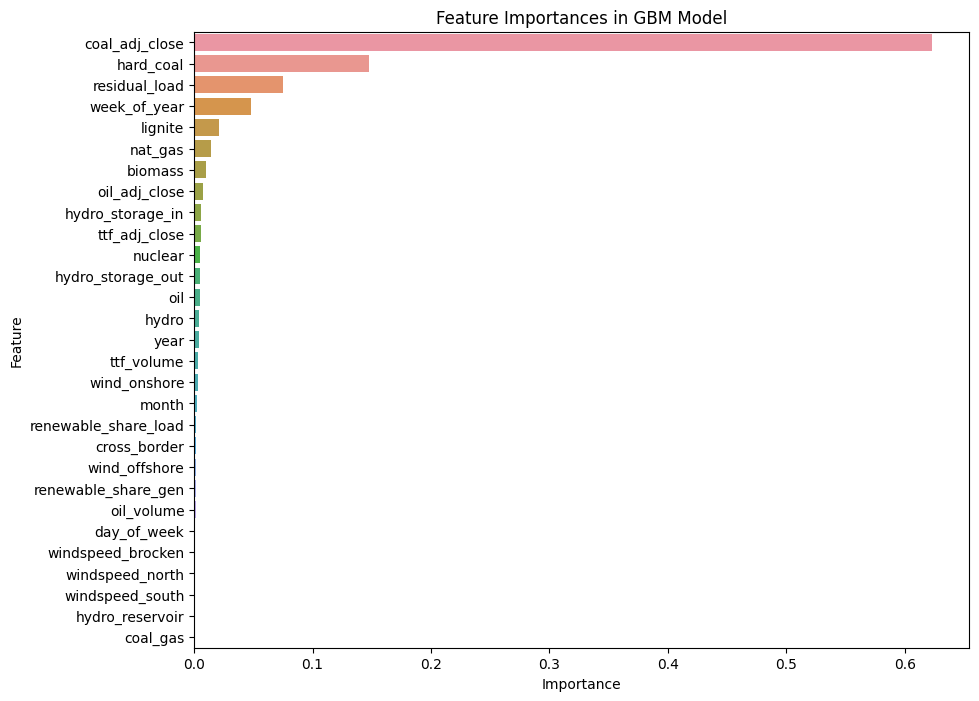

In [116]:
feature_importances = best_gbm_model.feature_importances_

# extract feature importances and create df to plot
features = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Make barplot of feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=features)
plt.title('Feature Importances in GBM Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Error Analysis

Obtain predictions and residuals:

In [117]:
# Predictions
y_train_pred = best_gbm_model.predict(X_train)
y_test_pred = best_gbm_model.predict(X_test)

# Residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred


### Plot Residuals

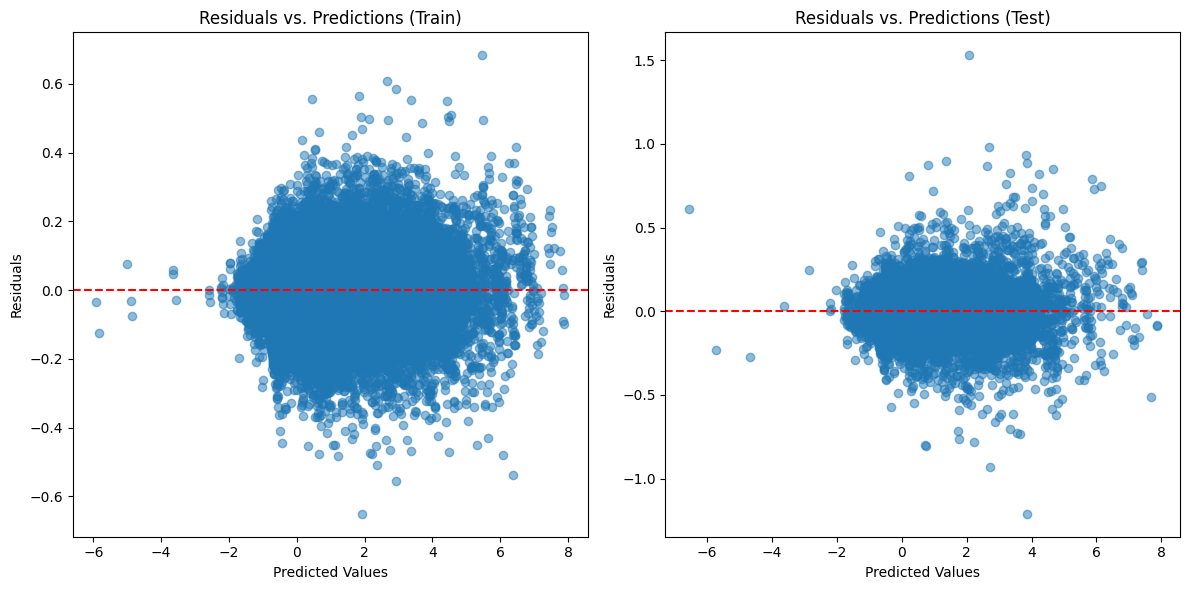

In [118]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_train_pred, train_residuals, alpha=0.5)
plt.title('Residuals vs. Predictions (Train)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')

plt.subplot(1, 2, 2)
plt.scatter(y_test_pred, test_residuals, alpha=0.5)
plt.title('Residuals vs. Predictions (Test)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()


### Plot Distribution of Residuals

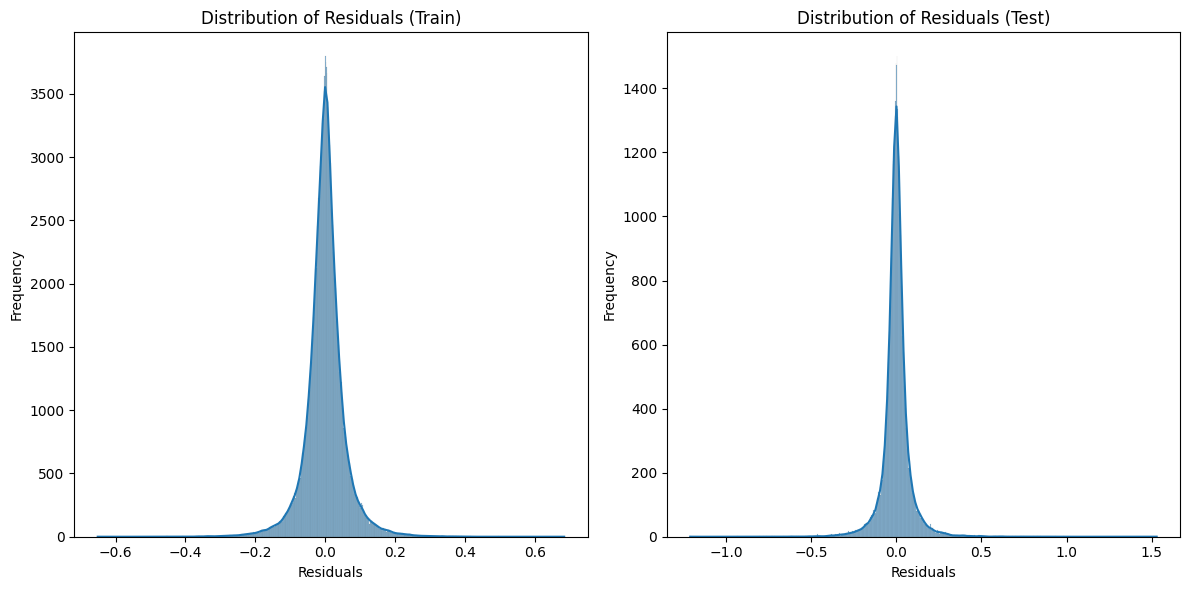

In [119]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(train_residuals, kde=True)
plt.title('Distribution of Residuals (Train)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(test_residuals, kde=True)
plt.title('Distribution of Residuals (Test)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# Finalize the Model

fit with full dataset (before train test split)

In [14]:
# Train Full model
gbm_final = GradientBoostingRegressor(learning_rate=0.2, max_depth=7, n_estimators=300, random_state=42, min_samples_split=10,)
gbm_final.fit(X, y)  # X and y represent our full dataset

# Save the model
joblib.dump(gbm_final, 'gbm_final_opt_model.pkl')


['gbm_final_opt_model.pkl']

# Predict and Plot

Predicting the Day-Ahead-Prices of the last two weeks 

In [15]:
# dataset contains the scaled target -> drop it
X_last_two_weeks_data = last_two_weeks_data.drop('day_ahead_price_scaled', axis=1)


In [16]:
# Make prediction
y_pred_last_two_weeks = gbm_final.predict(X_last_two_weeks_data)


In [17]:
# Compare Predictions with Actual Values
actual_prices = last_two_weeks_data['day_ahead_price_scaled'].values
predicted_prices = y_pred_last_two_weeks  # the predictions

# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({'Actual Price': actual_prices, 'Predicted Price': predicted_prices})


In [22]:
actual_prices = last_two_weeks_data['day_ahead_price_scaled'].values
predicted_prices = y_pred_last_two_weeks  # the predictions

# Create a DataFrame for easy comparison
comparison_df = pd.DataFrame({'Actual Price': actual_prices, 'Predicted Price': predicted_prices})


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Absolute Error: 0.44594597372150235
Mean Squared Error: 0.37225971796624374
R-squared: -1.8589223215507702


In [24]:
# Inverse_transform with our StandardScaler instance used for the target variable
predicted_prices_unscaled = scaler.inverse_transform(predicted_prices.reshape(-1, 1)).flatten()

# Retrieving the actual unscaled prices
actual_prices_unscaled = unscaled_target.loc[last_two_weeks_data.index].values.flatten()


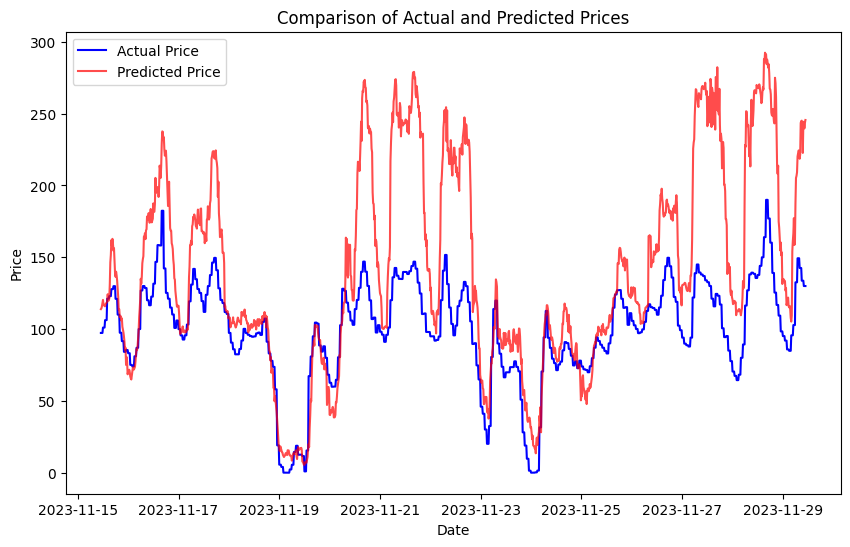

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(last_two_weeks_data.index, actual_prices_unscaled, label='Actual Price', color='blue')
plt.plot(last_two_weeks_data.index, predicted_prices_unscaled, label='Predicted Price', color='red', alpha=0.7)
plt.title('Comparison of Actual and Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Problem: scaling test and train data with same scaler leads to data leakage!!!!!

# Optional: Learning Curve for Final Model

Attention: Compuationally heavy

In [ ]:
import numpy as np
train_sizes = np.linspace(0.1, 1.0, 10)  # For example, 10% to 100% of the training data

from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator = GradientBoostingRegressor(learning_rate=0.2, max_depth=7, n_estimators=300, min_samples_split=10, random_state=42),
    X = X,  # Your full dataset
    y = y,  # Target values
    train_sizes = train_sizes,
    cv = 5,  # Number of folds in cross-validation
    scoring = 'r2'  # Scoring metric
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)


In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("R-squared Score")
plt.legend(loc="best")
plt.grid()
plt.show()
